In [ ]:
#import pandas for data processing
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def remove_repeat(file_ls,svd_fil):
  #try to read in the saved data
  try:
    saved_s=pd.read_csv(svd_fil,index_col=0,header=None,squeeze=True)
  except FileNotFoundError:
    print('History file not found, all data files being processed')
    return file_ls,False
  
  #somewhat clunky (but effective) method for checking if we've processed a file already
  temp_s=pd.Series(file_ls)
  tf_ls=temp_s.isin(saved_s)
  idx_ls=[]
  for i in range(0,len(tf_ls)):
    if tf_ls[i]:
      idx_ls.append(i)
  temp_s.drop(index=idx_ls,inplace=True)
  return temp_s.tolist(),True

In [ ]:
def fname_ls_builder(fin_path):
  #Find all files in data directory
  from os import listdir
  from os.path import isfile, join
  return [f for f in listdir(fin_path) if isfile(join(fin_path,f))]

In [ ]:
def peaks_cleaning(df):
  #additional cleaning for peaks - drop NA rows, scale features
  df.dropna(inplace=True)

  #scale data((X-mean)/std_dev)
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()
  temp_df=pd.DataFrame(sc.fit_transform(df),columns=df.columns)
  return temp_df

In [ ]:
def df_builder(fin_path,fname_ls):
  #this function imports data from CSV files to one large dataframe

  #create list to hold dataframes
  df_ls=[]

  #read in each file
  for i in fname_ls:
    temp_df=pd.read_csv(fin_path+i,index_col=0)
    #print(i,'loaded\n\n')
    df_ls.append(temp_df)

  #create one large df
  df=pd.concat(df_ls)
  print(df)

  #if peaks data, additional cleaning
  if 'Peaks Only' in fin_path:
    df=peaks_cleaning(df)

  print('Master data set shape is',df.shape,'\n\n')
  return df

In [ ]:
def import_data(saved_data=None,explore=True):
  #import data from CSV files
  f_path=r'/content/drive/My Drive/ML Spectroscopy/Data/Preprocessed/'
  m_path=r'/content/drive/My Drive/ML Spectroscopy/Models/'

  cwt_in=f_path+r'Continuous Wavelet Transformation/Unlabeled/'
  pk_in=f_path+r'Peaks Only/Unlabeled/'

  cwt_fname_ls=fname_ls_builder(cwt_in)
  pk_fname_ls=fname_ls_builder(pk_in)

  #removed for data exploration - when used for labeling again, uncomment and remove following line
  fflag=False
  '''
  if not explore:
    cwt_fname_ls,fflag=remove_repeat(file_ls=cwt_fname_ls,svd_fil=saved_data)
    pk_fname_ls,fflag=remove_repeat(file_ls=pk_fname_ls,svd_fil=saved_data)

    if not pk_fname_ls:
      raise ValueError('No new files')
  '''
  cwt_df=df_builder(cwt_in,cwt_fname_ls)
  pk_df=df_builder(pk_in,pk_fname_ls)

  if explore:
    return cwt_df,pk_df
  return cwt_df,pk_df,fflag,cwt_fname_ls,pk_fname_ls


In [ ]:
def pca_process(X_cwt,X_pk):
  from sklearn.decomposition import PCA
  #let the fit function itself divide the data into batches
  X_cwt_pca=PCA(n_components=3).fit_transform(X_cwt)
  X_pk_pca=PCA(n_components=3).fit_transform(X_pk)
  return X_cwt_pca,X_pk_pca

In [ ]:
def kmeans_elbow(X,k,desc):
  #import kmeans, plt, np, cdist, and metrics
  from sklearn.cluster import KMeans
  from sklearn import metrics 
  from scipy.spatial.distance import cdist 
  import numpy as np 
  #define empty lists for later use in elbow methods
  X_distortions=[] 
  X_inertias=[]

  #loop to run kmeans and find the elbow
  for i in k:
  #create a model with [1,10] clusters and fit to X, -1 n_jobs runs parallel operations
    model=KMeans(n_clusters=i,n_jobs=-1).fit(X)

    #measure and track distortion and inertia for elbow method
    X_distortions.append(sum(np.min(cdist(X,model.cluster_centers_,'euclidean'),axis=1))/X.shape[0])
    X_inertias.append(model.inertia_)


    #count how many samples per cluster
    check_set=model.predict(X)
    check_list=[0,0,0,0,0,0,0,0,0,0]
    for i in check_set:
      check_list[i]+=1
    print(check_list)

  elbow_plt(k,X_distortions,desc,'Distortions')
  elbow_plt(k,X_inertias,desc,'Inertias')



In [ ]:
def elbow_plt(k,y_vals,desc,plt_type):
  import matplotlib.pyplot as plt
  #show elbow for distortions
  plt.plot(k, y_vals, 'bx-') 
  plt.xlabel('Values of K') 
  plt.ylabel(plt_type) 
  plt.title(desc) 
  plt.show()


In [ ]:
def elbow_explore():
  #import data
  X_cwt,X_pk=import_data()

  #store the indices mappings
  X_cwt_og_map=X_cwt.index.values
  X_pk_og_map=X_pk.index.values

  #process with PCA
  X_cwt_pca,X_pk_pca=pca_process(X_cwt,X_pk)

  #define range for K for later use
  k=range(2,11)
  
  #run elbow method on each data set
  kmeans_elbow(X_cwt,k,'Elbow method for CWT')
  kmeans_elbow(X_pk,k,'Elbow method for PK')
  kmeans_elbow(X_cwt_pca,k,'Elbow method for CWT with PCA')
  kmeans_elbow(X_pk_pca,k,'Elbow method for PK with PCA')

'''uncomment to see elbow plots'''
#elbow_explore()

'uncomment to see elbow plots'

Due to the significantly clearer signals from the models built from the pk_ data rather than the cwt_ data, only the pk_ data will be used for labelling purposes. 

In [ ]:
def kmeans_spec(X,k,predict_store):
  #import kmeans, plt, np, cdist, and metrics
  from sklearn.cluster import KMeans
  from sklearn import metrics 
  from scipy.spatial.distance import cdist 
  import numpy as np 

  #create a model with [1,10] clusters and fit to X, -1 n_jobs runs parallel operations
  model=KMeans(n_clusters=k,n_jobs=-1).fit(X)


  #count how many samples per cluster
  check_set=model.predict(X)
  print(check_set.shape)
  check_list=[0,0,0,0,0,0,0,0,0,0]
  for i in check_set:
    check_list[i]+=1
  print(check_list)
  predict_store['pred_labels']=check_set
  print(predict_store.shape)
  return predict_store

In [ ]:
def spot_check_label(X,X2,X_labels):
  import matplotlib.pyplot as plt
  for i in range(0,len(X),10000):
    #data spot check 
    plt.plot(X.columns.values,X.iloc[i])  
    plt.title(X_labels['pred_labels'].iloc[i]) 
    plt.show()
    plt.plot(X2.columns.values,X2.iloc[i])  
    plt.title(X_labels['pred_labels'].iloc[i]) 
    plt.show()
    print('\n\n\n\n\n')

                                         150       155  ...      1090      1095
granite0dust_test_015s_5184_ds2-0  -0.051427  0.163273  ...  0.391396  0.226191
granite0dust_test_015s_5184_ds2-1  -0.049593  0.118792  ...  0.303744  0.174256
granite0dust_test_015s_5184_ds2-2  -0.053634  0.130451  ...  0.329248  0.188565
granite0dust_test_015s_5184_ds2-3  -0.052359  0.112879  ...  0.300975  0.173222
granite0dust_test_015s_5184_ds2-4  -0.061962  0.312511  ...  0.877075  0.516090
...                                      ...       ...  ...       ...       ...
granite50dust_test_015s_10000-9995 -0.013295  0.463382  ...  0.878192  0.514982
granite50dust_test_015s_10000-9996 -0.001401  0.520431  ...  0.856907  0.507203
granite50dust_test_015s_10000-9997 -0.009746  0.512831  ...  0.884811  0.525812
granite50dust_test_015s_10000-9998  0.002349  0.522403  ...  0.870001  0.515793
granite50dust_test_015s_10000-9999 -0.001015  0.521826  ...  0.862767  0.510514

[129504 rows x 190 columns]
Master data

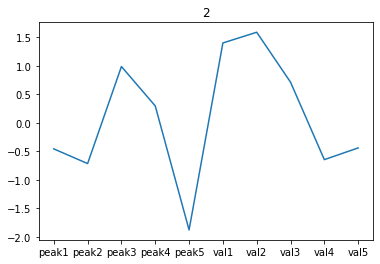

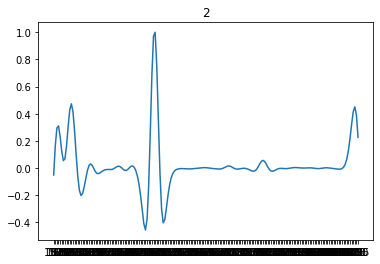

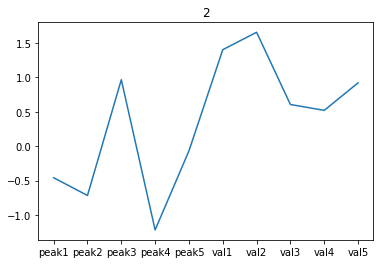

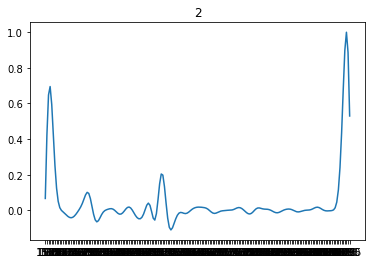

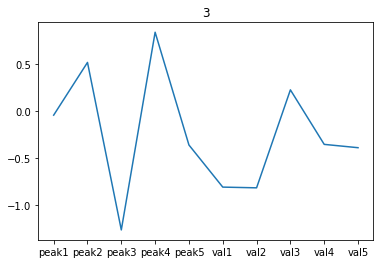

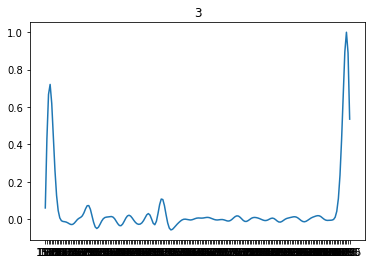

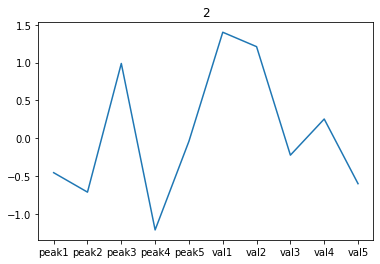

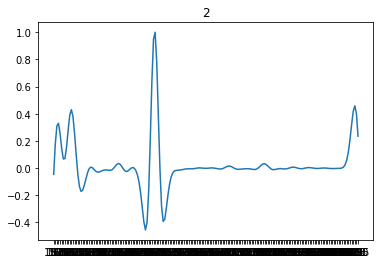

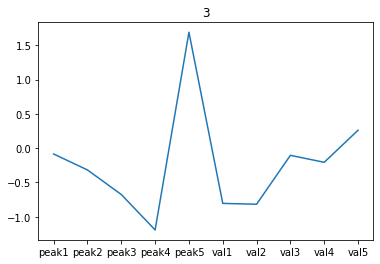

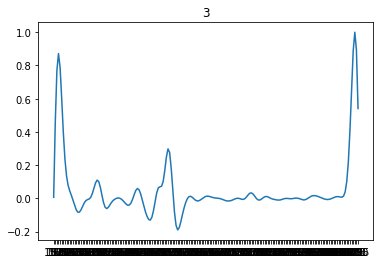

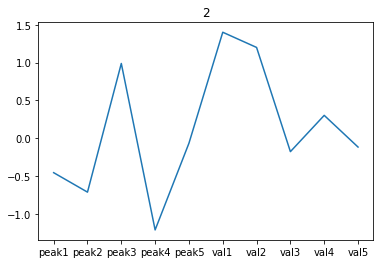

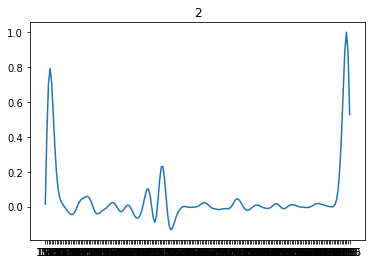

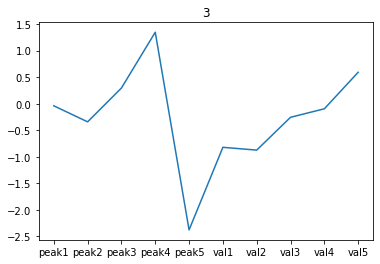

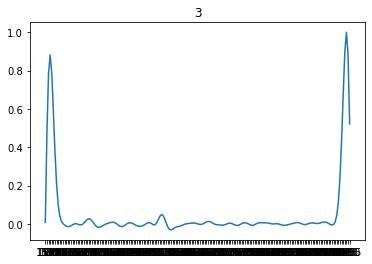

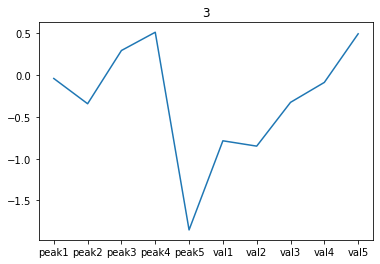

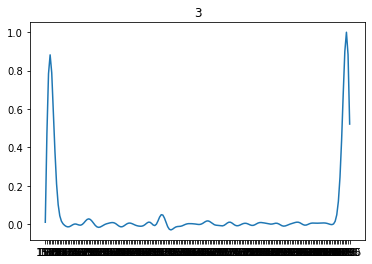

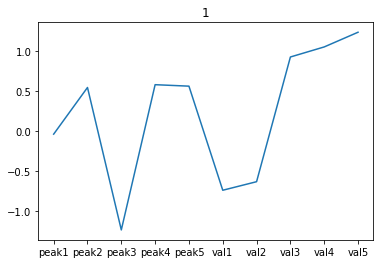

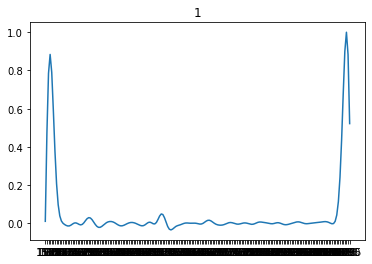

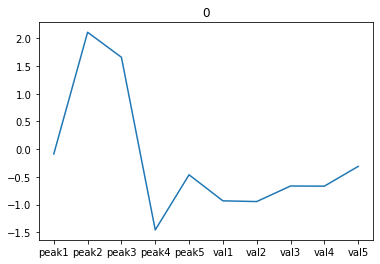

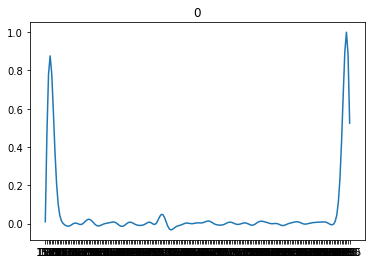

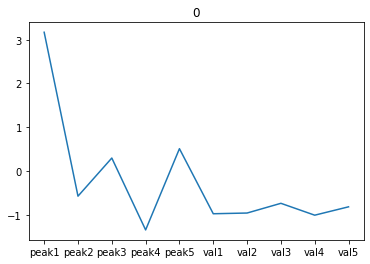

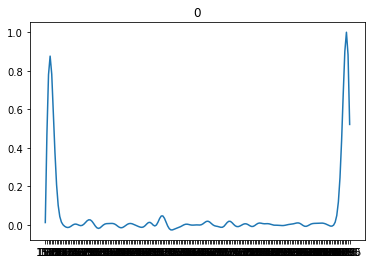

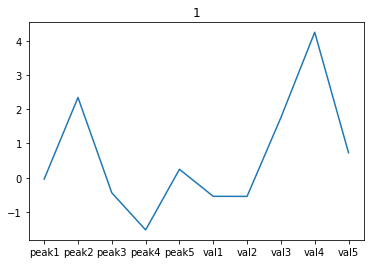

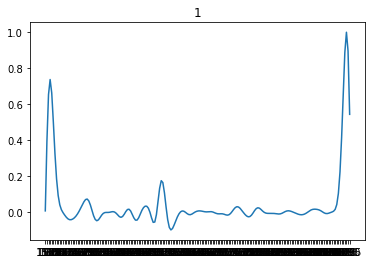

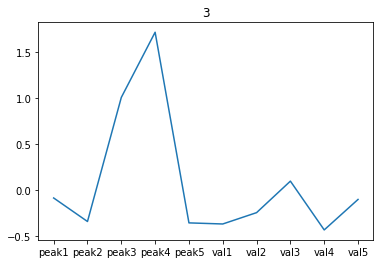

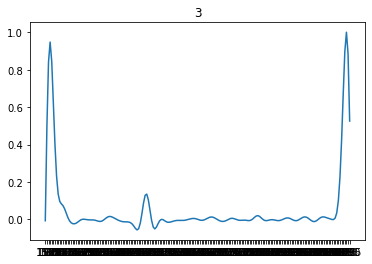

In [ ]:
def labeling_model(k):
  #import data
  saved_data=r'/content/drive/My Drive/ML Spectroscopy/Programs/Data Processing/Saved Lists/clustered.csv'
  X_cwt,X_pk,fflag,cwt_ls,pk_ls=import_data(saved_data,explore=False)
  
  #store the new-index-to-original mapping and drop from large dataset
  X_cwt_og_map=pd.DataFrame(X_cwt.index.values,columns=['og-idx'])
  X_pk_og_map=pd.DataFrame(X_pk.index.values,columns=['og-idx'])

  #process with PCA - data exploration suggests against pca
  #X_cwt_pca,X_pk_pca=pca_process(X_cwt,X_pk)

  #specific cluster model
  X_pk_og_map=kmeans_spec(X_pk,k,X_pk_og_map)
  print(X_pk_og_map)

  #spot check clusters
  spot_check_label(X_pk,X_cwt,X_pk_og_map)

  #disabled file saving for exploration
  '''
  X_pk_og_map.to_csv('/content/drive/My Drive/ML Spectroscopy/Data/Preprocessed/Clustered Data/granite_labels_4.csv')
  print('file saved')

  if fflag:
    pd.Series(cwt_ls).to_csv(saved_data,mode='a')
    pd.Series(pk_ls).to_csv(saved_data,mode='a')
  else:
    pd.Series(cwt_ls).to_csv(saved_data,mode='w')
    pd.Series(pk_ls).to_csv(saved_data,mode='a')
  '''

labeling_model(4)